#### 设置全局参数

In [1]:
import torch
device = torch.device("cuda:1") 
dataset_type = "SteeringAngle"
model_name = "null"
save_origin_pic = False # 是否保留原始图片
save_generate_pic = True # 是否保留生成图片
fid_judge = False # 是否进行fid评估

### 加载相应的库

In [2]:
import sys
python_files_dir = "./python_files/" # python工具包位置
sys.path.append(python_files_dir)
import my_tools
import fid_score as official_fid

model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as all_model

if dataset_type == "CIFAR10":
    if model_name == "ResNet20":
        from CIFAR10.models import ResNet20 as classify_model
        from CIFAR10.models import Rob_predictor as my_Rob_predictor
        from CIFAR10.models import BigGAN


import pickle
import os
import numpy as np
from tqdm import tqdm
from PIL import Image  
from openTSNE import TSNE
import matplotlib.pyplot as plt
import copy
import pandas as pd
import seaborn as sns
import random

import torch
import torch.nn as nn
import torchvision
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import h5py

number = 100

### 保留生成图片与z

In [3]:
if save_generate_pic == True and dataset_type == "SteeringAngle":
    print("处理SteeringAngle。。。")
    checkpoints_path = "./model_files/SteeringAngle/checkpoints/CcGAN/ckpt_CcGAN_niters_40000_seed_2020_soft.pth"
    G = all_model.get_generative_model("SteeringAngle")
    G = nn.DataParallel(G, device_ids=[1])
    G.load_state_dict(torch.load(checkpoints_path, map_location=device)["netG_state_dict"])
    G = G.to(device)
    G.eval()

    net_y2h = all_model.get_mapping("SteeringAngle").to(device)
    net_y2h_checkpoint = torch.load("./model_files/SteeringAngle/checkpoints/CcGAN/ckpt_net_y2h_epoch_500_seed_2020.pth", map_location=device)
    net_y2h.load_state_dict(net_y2h_checkpoint['net_state_dict'])
    net_y2h.eval()

    # number = 50000

    
    for num in tqdm(range(number)):
        z = torch.tensor(np.random.RandomState(num).randn(1, 256)).to(torch.float32).to(device)    # latent code
        random.seed(num)
        angle = torch.tensor(random.uniform(0.0, 0.3)).unsqueeze(0).to(device) 
        y_embed = net_y2h(angle)

        img = G(z, y_embed) # NCHW, float32, dynamic range [-1, +1]
        img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
        if num == 0:
            imgs = img
        else:
            imgs = torch.cat((imgs,img))

        z_and_embed_y = torch.cat((z, y_embed), dim = 1)
        if num == 0:
            z_and_embed_ys = z_and_embed_y
            angles = angle
        else:
            z_and_embed_ys = torch.cat((z_and_embed_ys, z_and_embed_y))
            angles = torch.cat((angles, angle))


处理SteeringAngle。。。


100%|██████████| 100/100 [00:01<00:00, 91.18it/s]


In [4]:
print(imgs.shape)

torch.Size([100, 3, 64, 64])


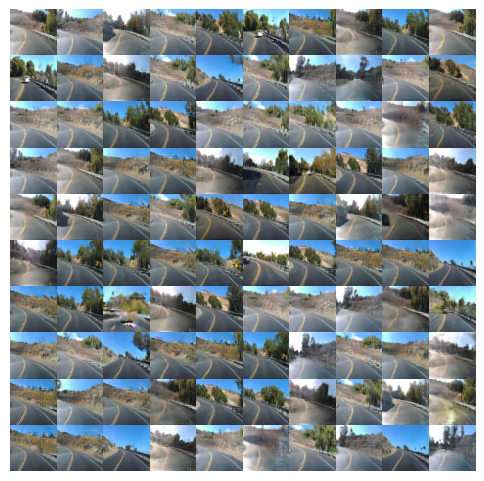

In [5]:
# q1 = -80.0
# q2 = -48.0
# indx = np.where((labels>q1)*(labels<q2)==True)[0]
# labels = labels[indx]
# images = images[indx]

import random
import matplotlib.pyplot as plt
import numpy

images = imgs.cpu().detach().numpy()

# Randomly select 100 indices from the array
indices = random.sample(range(len(images)), 100)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(10, 10, figsize=(6, 6))
plt.subplots_adjust(wspace=0, hspace=0)

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop over the first 9 images and plot them in separate subplots
for i, idx in enumerate(indices):
    # Get the i-th image from the array
    img = images[idx]
    
    # Reshape the image from (3, 64, 64) to (64, 64, 3)
    img = img.transpose((1, 2, 0))
    
    # Plot the image in the i-th subplot
    axes[i].imshow(img)
    axes[i].set_axis_off()
    
# Display the subplots
plt.show()